In [105]:
import numpy as np
import pandas as pd
import re
import gensim

import warnings
warnings.filterwarnings('ignore')
# /kaggle/input/amazon_reviews.txt

In [141]:
data = pd.read_csv("/kaggle/input/1-preprocessing/data_df.csv",sep="\t")
data.head()

,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,REVIEW_TEXT
0,1,4,0,9,"['useful', 'think', 'product', 'save', 'day', ..."
1,1,4,1,22,"['new', 'era', 'battery', 'lithium', 'battery'..."
2,1,3,0,18,"['doesn', 'swing', 'purchase', 'swing', 'baby'..."
3,1,4,0,15,"['great', 'computing', 'look', 'inexpensive', ..."
4,1,4,0,28,"['use', 'twice', 'week', 'use', 'twice', 'week..."


In [146]:
data['REVIEW_TEXT'] = data['REVIEW_TEXT'].apply(lambda x:" ".join(eval(x)))
data.drop('PRODUCT_CATEGORY',axis=1,inplace=True)

In [142]:
data['RATING'] = data['RATING'].apply(lambda x: int(x>3))

In [149]:
data["LABEL"] = data["LABEL"].apply(lambda x: int(x==1))

In [151]:
%%time
documents = []
for _text in data.REVIEW_TEXT:    
    documents.append((_text.split(" ")))

CPU times: user 82.3 ms, sys: 0 ns, total: 82.3 ms
Wall time: 82.2 ms


In [159]:
W2V_SIZE = 48
W2V_WINDOW = 7
W2V_EPOCH = 64
W2V_MIN_COUNT = 5
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)


w2v_model.build_vocab(documents)

In [160]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 1min 53s, sys: 607 ms, total: 1min 53s
Wall time: 1min


(36890745, 43163392)

In [161]:
w2v_model.most_similar("bad")

[('terrible', 0.6807401180267334),
 ('poor', 0.6042301058769226),
 ('useless', 0.6033514738082886),
 ('obviously', 0.5642818212509155),
 ('anymore', 0.5543418526649475),
 ('surprising', 0.5447155833244324),
 ('skip', 0.5397471785545349),
 ('horrible', 0.5211291909217834),
 ('awful', 0.5055249333381653),
 ('junk', 0.49995970726013184)]

In [162]:
np.mean(data.REVIEW_TEXT.map(len))

202.9610476190476

In [163]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model,Sequential
from keras.layers import Input,concatenate,Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D,Bidirectional, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping


In [164]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data.REVIEW_TEXT)
vocab_size = len(tokenizer.word_index)+1
print('Vocab Size is ',vocab_size)

Vocab Size is  27031


In [165]:
SEQUENCE_LENGTH = 180

In [166]:
embedding_matrix = np.zeros((vocab_size , W2V_SIZE))
for word , i in tokenizer.word_index.items():
    if word in w2v_model.wv:
        embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(27031, 48)


In [167]:
data.LABEL.value_counts()

1    10500
0    10500
Name: LABEL, dtype: int64

In [168]:
ones = data[data["LABEL"]==1]
twos = data[data["LABEL"]==0]

In [169]:
train_data = ones[:7500]
train_data = train_data.append(twos[:7500])
val_data = ones[7500:8000]
val_data = val_data.append(twos[7500:8000])
print(train_data.shape)
print(val_data.shape)

(15000, 4)
(1000, 4)


In [170]:
test_data = ones[8000:]
test_data = test_data.append(twos[8000:])
test_data.shape

(5000, 4)

In [171]:
data_nlp = train_data["REVIEW_TEXT"]
data_meta_input = train_data.drop(["REVIEW_TEXT","LABEL"],axis=1)
data_op = train_data["LABEL"]

val_nlp = val_data["REVIEW_TEXT"]
val_meta_input = val_data.drop(["REVIEW_TEXT","LABEL"],axis=1)
val_op = val_data["LABEL"]

In [172]:
test_data_nlp = test_data["REVIEW_TEXT"]
test_data_meta_input = test_data.drop(["REVIEW_TEXT","LABEL"],axis=1)
test_data_op = test_data["LABEL"]

In [173]:
%%time 
x_data = pad_sequences(tokenizer.texts_to_sequences(data_nlp) , maxlen = SEQUENCE_LENGTH)
y_data = data_op
y_data = y_data.values.reshape(-1,1)

CPU times: user 683 ms, sys: 5.52 ms, total: 689 ms
Wall time: 688 ms


In [174]:
%%time 
vx_data = pad_sequences(tokenizer.texts_to_sequences(val_nlp) , maxlen = SEQUENCE_LENGTH)
vy_data = val_op
vy_data = vy_data.values.reshape(-1,1)

CPU times: user 45.8 ms, sys: 3.01 ms, total: 48.8 ms
Wall time: 48.6 ms


In [186]:
%%time 
testx = pad_sequences(tokenizer.texts_to_sequences(test_data_nlp) , maxlen = SEQUENCE_LENGTH)
testy = test_data_op
testy = testy.values.reshape(-1,1)

CPU times: user 217 ms, sys: 3.89 ms, total: 221 ms
Wall time: 219 ms


In [175]:
nlp_input = Input(shape=(SEQUENCE_LENGTH,)) 

# meta_input = Input(shape=(3,))
                   
emb=Embedding(vocab_size,W2V_SIZE,weights=[embedding_matrix],input_length=SEQUENCE_LENGTH)(nlp_input)
     
nlp_out = LSTM(64)(emb) 
# concat = concatenate([nlp_out, meta_input]) 
                        
classifier1 = Dense(128, activation='relu')(nlp_out) 
dropout = Dropout(0.2)(classifier1) 
classifier2 = Dense(32, activation='relu')(dropout) 
output = Dense(1, activation='sigmoid')(classifier2) 

model = Model(inputs=[nlp_input], outputs=[output])

In [176]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [177]:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 180)               0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 180, 48)           1297488   
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                28928     
_________________________________________________________________
dense_23 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 33 

In [178]:
history = model.fit(x_data,y_data,batch_size=32,epochs=3,
                    validation_data=(vx_data,vy_data))

Train on 15000 samples, validate on 1000 samples
Epoch 1/3
15000/15000 [==============================] - 83s 6ms/step - loss: 0.6708 - accuracy: 0.5813 - val_loss: 0.6711 - val_accuracy: 0.6080
Epoch 2/3
15000/15000 [==============================] - 81s 5ms/step - loss: 0.6212 - accuracy: 0.6581 - val_loss: 0.6806 - val_accuracy: 0.5910
Epoch 3/3
15000/15000 [==============================] - 81s 5ms/step - loss: 0.5686 - accuracy: 0.7059 - val_loss: 0.7106 - val_accuracy: 0.5970


In [180]:
history2 = model.fit(x_data,y_data,batch_size=32,epochs=10,initial_epoch=4,
                    validation_data=(vx_data,vy_data))

Train on 15000 samples, validate on 1000 samples
Epoch 5/10
15000/15000 [==============================] - 82s 5ms/step - loss: 0.5000 - accuracy: 0.7538 - val_loss: 0.7469 - val_accuracy: 0.6100
Epoch 6/10
15000/15000 [==============================] - 81s 5ms/step - loss: 0.4208 - accuracy: 0.8063 - val_loss: 0.8787 - val_accuracy: 0.5930
Epoch 7/10
15000/15000 [==============================] - 82s 5ms/step - loss: 0.3332 - accuracy: 0.8548 - val_loss: 0.8931 - val_accuracy: 0.6060
Epoch 8/10
15000/15000 [==============================] - 80s 5ms/step - loss: 0.2399 - accuracy: 0.9005 - val_loss: 1.2255 - val_accuracy: 0.5920
Epoch 9/10
15000/15000 [==============================] - 80s 5ms/step - loss: 0.1634 - accuracy: 0.9366 - val_loss: 1.5197 - val_accuracy: 0.6010
Epoch 10/10
15000/15000 [==============================] - 83s 6ms/step - loss: 0.1159 - accuracy: 0.9554 - val_loss: 1.8573 - val_accuracy: 0.5970


In [183]:
model.save("Word2Vec.hdf5")

In [185]:
from sklearn.metrics import confusion_matrix

In [188]:
pred = model.predict(testx)
# np.unique(pred,return_counts=True)

In [194]:
pred = (pred>0.5)

In [202]:
pred = pred.reshape(5000).astype(int)
np.unique(pred , return_counts=True)

(array([0, 1]), array([2136, 2864]))

In [ ]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True)

In [203]:
confusion_matrix(pred,testy)

array([[1252,  884],
       [1248, 1616]])

In [208]:
import matplotlib.pyplot as plt

AUC score is:  0.5736


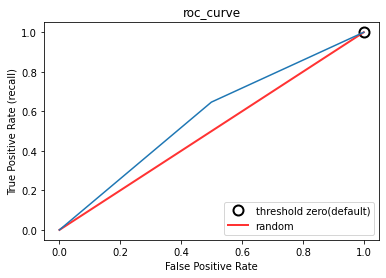

In [210]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(testy, pred)

# find threshold closest to zero:
close_zero = np.argmin(np.abs(thresholds))

plt.plot(fpr[close_zero], tpr[close_zero], 'o', 
         markersize=10, label="threshold zero(default)", fillstyle="none", c='k', mew=2)
plt.plot([0,1], linestyle='-', lw=2, color='r', label='random', alpha=0.8)
plt.legend(loc=4)
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (recall)")
plt.title("roc_curve");

from sklearn.metrics import auc
print("AUC score is: ", auc(fpr, tpr));